In [ ]:
# set visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
import os
os.chdir("/workspace/")
import sys
sys.path.append("/workspace/reni_neus")


import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni_neus.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import get_directions, get_sineweight, look_at_target
from reni_neus.illumination_fields.reni_field import RENIField
from reni_neus.data.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.reni_neus_config import RENINeuS as RENINeuSMethodSpecification, DirectionalDistanceField  

def sRGB(imgs):
    # Add batch dimension if necessary
    if imgs.ndim == 3:
        imgs = imgs.unsqueeze(0)
    
    # Calculate the 98th percentile for each image
    q = torch.quantile(imgs.view(imgs.size(0), -1), 0.98, dim=1)
    
    # Normalize images by their 98th percentile
    imgs = imgs / q.view(-1, 1, 1, 1)
    
    # Clamp the pixel values between 0.0 and 1.0
    imgs = torch.clamp(imgs, 0.0, 1.0)
    
    # Convert linear RGB to sRGB using the sRGB conversion formula
    mask = imgs <= 0.0031308
    imgs_sRGB = imgs = torch.where(
        imgs <= 0.0031308,
        12.92 * imgs,
        1.055 * torch.pow(torch.abs(imgs), 1 / 2.4) - 0.055,
    )
    return imgs_sRGB

def rotation_matrix(axis, angle):
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

ckpt_path = '/workspace/outputs/unnamed/reni-neus/2023-05-17_071604/'
step = 95000

ckpt = torch.load(ckpt_path + '/nerfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        model_dict[key[7:]] = ckpt['pipeline'][key]

# load yaml checkpoint config
config_path = Path(ckpt_path) / 'config.yml'
config = yaml.load(config_path.open(), Loader=yaml.Loader)
pipeline_config = config.pipeline

datamanager: RENINeuSDataManager = pipeline_config.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)
# includes num_eval_data as needed for reni latent code fitting.
model = pipeline_config.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    num_eval_data=len(datamanager.eval_dataset),
    metadata=datamanager.train_dataset.metadata,
)
model.to(device)
model.load_state_dict(model_dict)
model.eval()

print('Model loaded')

Variable resolution, using variable_res_collate

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 5 images.

Output()

Model loaded


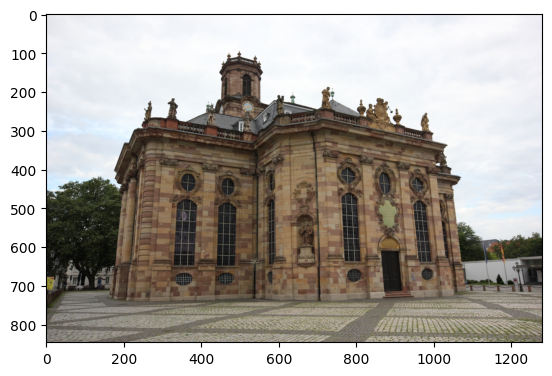

In [2]:
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(0)
plt.imshow(batch['image'].cpu().numpy())

In [5]:
model.config.render_only_albedo = True
model.illumination_sampler.set_icosphere_order(2)
ray_bundle.nears = torch.zeros_like(ray_bundle.metadata['directions_norm']) + 0.05
ray_bundle.fars = torch.zeros_like(ray_bundle.metadata['directions_norm']) + 1.0
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True)

Output()

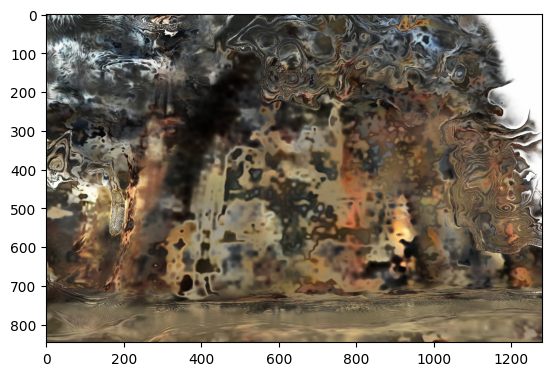

In [6]:
plt.imshow(outputs['albedo'].cpu().numpy())